In [1]:
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
%load_ext autoreload
%autoreload 2

## Key Ideas

The `LassoNetCoxRegressor` architecture is based on the `LasssoNet` described in 
the `feature_selection_lasso_net` notebook. The main difference is in the loss function with `CoxPHLoss`
implemented below. <br/> <br/>
**Inputs**
- The first parameter of the loss function $g(x)$ comes from the forward step of the neural net model where each row is a sample, and each column is a feature. Each row is associated with an event time $t_i$ (that can produce ties) and an indicator $\delta_i$ indicating whether the event is censored or not (1 if uncensored). 
- The second parameter of the loss function consists of the duration $t_i$ and status $\delta_i$.

The function sorts  the event times $t_i$ in decreasing order; and computes the negative log likelihood as: 
<br/>
<br/>
$$
    L_i(g) = \frac{\lambda(t_i|X_i)} {\sum_{j:t_j\ge t_i} \lambda(t_j|X_j) } =
    \prod_{i|\delta_i=1} \frac{\exp{(g(x_i))}}  {\sum_{j:t_j\ge t_i}\exp{(g(x_j))}}
$$ <br/>
$$
 \text{LL(g)} = \sum_i \log{ \sum_j \exp{[g(x_j)]}} - g(x_i)
$$

Tied events are handled following Breslow or Effron methods:
1. First sort the hazard coefficients $g(x_i)$ and the events by ascending duration
2. The Breslow method take `logcumsumexp` by tie for each event as $\mathbb{E} \sum_i \log{ \sum_j \exp{[g(x_j)]}}$
and the negative log likelihood is:
<br/> <br/>
$$
\text{LL(g)} = \mathbb{E} \sum_i \log{ \sum_j \exp{[g(x_j)]}} - \mathbb{E} g(x_i)
$$
3. The Effron approximations results in the following likelihood:

$$
    L(g) = \prod_{i \in J'} \frac{\prod_{j \in \mathcal{D}_i} \exp{g(x_i)}} 
    {\prod_{k=0}^{d_i-1} \bigg ( \sum_{j \in \mathcal{R}_i} \exp{(g(x_j))} - \frac{k}{d_i} \sum_{j \in \mathcal{D}_i} \exp{(g(x_j))} \bigg) } 
$$
If now we take the $\log$ of this expression, the previous equation can be decomposed into:
1. The numerator is the same as in the Breslow method
2. Then handle the denominator by:
    - Taking `logsumexp` of ties + $\log(d_i)$ - $\log(k_i)$
    - Then computing the difference: $\log(\exp()- \exp(y))$
    where $x$ = `logcumsumexp` of events, $y$= `logsumexp` of ties
    - Finally taking as denominator the mean of this difference
3. Returns (denominator - numerator) as loss value 

In [4]:
def scatter_reduce(input, dim, index, reduce, *, output_size=None):
        src = input
        if output_size is None:
            output_size = index.max() + 1
        return torch.empty(output_size, device=input.device).scatter_reduce(
            dim=dim, index=index, src=src, reduce=reduce, include_self=False
        )
    
def scatter_logsumexp(input, index, *, dim=-1, output_size=None):
    """Inspired by torch_scatter.logsumexp
    Uses torch.scatter_reduce for performance
    """
    max_value_per_index = scatter_reduce(
        input, dim=dim, index=index, output_size=output_size, reduce="amax"
    )
    max_per_src_element = max_value_per_index.gather(dim, index)
    recentered_scores = input - max_per_src_element
    sum_per_index = scatter_reduce(
        recentered_scores.exp(),
        dim=dim,
        index=index,
        output_size=output_size,
        reduce="sum",
    )
    return max_value_per_index + sum_per_index.log()

def log_substract(x, y):
    """log(exp(x) - exp(y)) = log(x (1-e^(y-x))) = x + log (1-e^(y-x)) """
    return x + torch.log1p(-(y - x).exp())

In [5]:
class CoxPHLoss(torch.nn.Module):
    """Loss for CoxPH model. """

    allowed = ("breslow", "efron")

    def __init__(self, method):
        super().__init__()
        assert method in self.allowed, f"Method must be one of {self.allowed}"
        self.method = method

    def forward(self, log_h, y):
        log_h = log_h.flatten()        

        durations, events = y.T

        # sort input
        durations, idx = durations.sort(descending=True)
        log_h = log_h[idx]
        events = events[idx]

        event_ind = events.nonzero().flatten()

        # numerator
        log_num = log_h[event_ind].mean()

        # logcumsumexp of events
        event_lcse = torch.logcumsumexp(log_h, dim=0)[event_ind]

        # number of events for each unique risk set
        _, tie_inverses, tie_count = torch.unique_consecutive(
            durations[event_ind], return_counts=True, return_inverse=True
        )

        # position of last event (lowest duration) of each unique risk set
        tie_pos = tie_count.cumsum(axis=0) - 1

        # logcumsumexp by tie for each event
        event_tie_lcse = event_lcse[tie_pos][tie_inverses]

        if self.method == "breslow":
            log_den = event_tie_lcse.mean()

        elif self.method == "efron":
            # based on https://bydmitry.github.io/efron-tensorflow.html

            # logsumexp of ties, duplicated within tie set
            tie_lse = scatter_logsumexp(log_h[event_ind], tie_inverses, dim=0)[
                tie_inverses
            ]
            # multiply (add in log space) with corrective factor
            aux = torch.ones_like(tie_inverses)
            aux[tie_pos[:-1] + 1] -= tie_count[:-1]
            event_id_in_tie = torch.cumsum(aux, dim=0) - 1
            discounted_tie_lse = (
                tie_lse
                + torch.log(event_id_in_tie)
                - torch.log(tie_count[tie_inverses])
            )
            # denominator
            log_den = log_substract(event_tie_lcse, discounted_tie_lse).mean()

        # loss is negative log likelihood
        return log_den - log_num

In [6]:
logh = torch.Tensor([-0.4, 0.3, 0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2])
log_h = logh.flatten()        
log_h

tensor([-0.4000,  0.3000,  0.4000, -0.3000, -0.2000, -0.1000,  0.0000,  0.1000,
         0.2000])

In [7]:
df = pd.DataFrame()
df = df.assign(**{
        "d": [1,1,1,2,3,4,5,5,7],
        "events":[1,0,1,1,0,1,1,1,1],
})
df

,d,events
0,1,1
1,1,0
2,1,1
3,2,1
4,3,0
5,4,1
6,5,1
7,5,1
8,7,1


In [8]:
CoxPHLoss("breslow")(logh, torch.Tensor(df.values))

tensor(1.4805)

In [9]:
CoxPHLoss("efron")(logh, torch.Tensor(df.values))

/var/folders/46/4k3zbt7527qgn5sdg7lzzxh80000gn/T/ipykernel_55404/3280320496.py:5: UserWarning: scatter_reduce() is in beta and the API may change at any time. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1615.)
  return torch.empty(output_size, device=input.device).scatter_reduce(


tensor(1.4085)

In [10]:
from sortedcontainers import SortedList

def concordance_index(risk, time, event):
    """
    O(n log n) implementation of https://square.github.io/pysurvival/metrics/c_index.html
    """
    assert len(risk) == len(time) == len(event)
    n = len(risk)
    order = sorted(range(n), key=time.__getitem__)
    past = SortedList()
    num = 0
    den = 0
    for i in order:
        num += len(past) - past.bisect_right(risk[i])
        den += len(past)
        if event[i]:
            past.add(risk[i])
    return num / den

In [11]:
durations, events = torch.Tensor(df.values).T

In [12]:
durations, events = torch.Tensor(df.values).T
concordance_index(log_h, durations, events)

0.24

In [13]:
from itertools import islice
from abc import ABCMeta, abstractmethod, abstractstaticmethod
from dataclasses import dataclass
from functools import partial
import itertools
import sys
from typing import List
import warnings

from sklearn.base import (
    BaseEstimator,
    ClassifierMixin,
    MultiOutputMixin,
    RegressorMixin,
)
from sklearn.model_selection import check_cv, train_test_split
import torch
from tqdm import tqdm

from src.lassonet.model import LassoNet

def abstractattr(f):
    return property(abstractmethod(f))


@dataclass
class HistoryItem:
    lambda_: float
    state_dict: dict
    objective: float  # loss + lambda_ * regularization
    loss: float
    val_objective: float  # val_loss + lambda_ * regularization
    val_loss: float
    regularization: float
    l2_regularization: float
    l2_regularization_skip: float
    selected: torch.BoolTensor
    n_iters: int

    def log(item):
        print(
            f"{item.n_iters} epochs, "
            f"val_objective "
            f"{item.val_objective:.2e}, "
            f"val_loss "
            f"{item.val_loss:.2e}, "
            f"regularization {item.regularization:.2e}, "
            f"l2_regularization {item.l2_regularization:.2e}"
        )


class BaseLassoNet(BaseEstimator, metaclass=ABCMeta):
    def __init__(
        self,
        *,
        hidden_dims=(100,),
        lambda_start="auto",
        lambda_seq=None,
        gamma=0.0,
        gamma_skip=0.0,
        path_multiplier=1.02,
        M=10,
        groups=None,
        dropout=0,
        batch_size=None,
        optim=None,
        n_iters=(1000, 100),
        patience=(100, 10),
        tol=0.99,
        backtrack=False,
        val_size=None,
        device=None,
        verbose=1,
        random_state=None,
        torch_seed=None,
        class_weight=None,
        tie_approximation=None,
    ):
        """
        Parameters
        ----------
        hidden_dims : tuple of int, default=(100,)
            Shape of the hidden layers.
        lambda_start : float, default='auto'
            First value on the path. Leave 'auto' to estimate it automatically.
        lambda_seq : iterable of float
            If specified, the model will be trained on this sequence
            of values, until all coefficients are zero.
            The dense model will always be trained first.
            Note: lambda_start and path_multiplier will be ignored.
        gamma : float, default=0.0
            l2 penalization on the network
        gamma : float, default=0.0
            l2 penalization on the skip connection
        path_multiplier : float, default=1.02
            Multiplicative factor (:math:`1 + \\epsilon`) to increase
            the penalty parameter over the path
        M : float, default=10.0
            Hierarchy parameter.
        groups : None or list of lists
            Use group LassoNet regularization.
            `groups` is a list of list such that `groups[i]`
            contains the indices of the features in the i-th group.
        dropout : float, default = None
        batch_size : int, default=None
            If None, does not use batches. Batches are shuffled at each epoch.
        optim : torch optimizer or tuple of 2 optimizers, default=None
            Optimizer for initial training and path computation.
            Default is Adam(lr=1e-3), SGD(lr=1e-3, momentum=0.9).
        n_iters : int or pair of int, default=(1000, 100)
            Maximum number of training epochs for initial training and path computation.
            This is an upper-bound on the effective number of epochs, since the model
            uses early stopping.
        patience : int or pair of int or None, default=10
            Number of epochs to wait without improvement during early stopping.
        tol : float, default=0.99
            Minimum improvement for early stopping: new objective < tol * old objective.
        backtrack : bool, default=False
            If true, ensures the objective function decreases.
        val_size : float, default=None
            Proportion of data to use for early stopping.
            0 means that training data is used.
            To disable early stopping, set patience=None.
            Default is 0.1 for all models except Cox for which training data is used.
            If X_val and y_val are given during training, it will be ignored.
        device : torch device, default=None
            Device on which to train the model using PyTorch.
            Default: GPU if available else CPU
        verbose : int, default=1
        random_state
            Random state for validation
        torch_seed
            Torch state for model random initialization
        class_weight : iterable of float, default=None
            If specified, weights for different classes in training.
            There must be one number per class.
        tie_approximation: str
            Tie approximation for the Cox model, must be one of ("breslow", "efron").
        """
        assert isinstance(hidden_dims, tuple), "`hidden_dims` must be a tuple"
        self.hidden_dims = hidden_dims
        self.lambda_start = lambda_start
        self.lambda_seq = lambda_seq
        self.gamma = gamma
        self.gamma_skip = gamma_skip
        self.path_multiplier = path_multiplier
        self.M = M
        self.groups = groups
        self.dropout = dropout
        self.batch_size = batch_size
        self.optim = optim
        if optim is None:
            optim = (
                partial(torch.optim.Adam, lr=1e-3),
                partial(torch.optim.SGD, lr=1e-3, momentum=0.9),
            )
        if isinstance(optim, partial):
            optim = (optim, optim)
        self.optim_init, self.optim_path = optim
        if isinstance(n_iters, int):
            n_iters = (n_iters, n_iters)
        self.n_iters = self.n_iters_init, self.n_iters_path = n_iters
        if patience is None or isinstance(patience, int):
            patience = (patience, patience)
        self.patience = self.patience_init, self.patience_path = patience
        self.tol = tol
        self.backtrack = backtrack
        if val_size is None:
            if isinstance(self, LassoNetCoxRegressor):
                val_size = 0
            else:
                val_size = 0.1
        self.val_size = val_size

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

        self.verbose = verbose

        self.random_state = random_state
        self.torch_seed = torch_seed

        self.model = None
        self.class_weight = class_weight
        self.tie_approximation = tie_approximation

        if self.class_weight is not None:
            assert isinstance(
                self, LassoNetClassifier
            ), "Weighted loss is only for classification"
            self.class_weight = torch.FloatTensor(self.class_weight).to(self.device)
            self.criterion = torch.nn.CrossEntropyLoss(
                weight=self.class_weight, reduction="mean"
            )
        if isinstance(self, LassoNetCoxRegressor):
            assert (
                self.batch_size is None
            ), "Cox regression does not work with mini-batches"
            assert (
                tie_approximation in CoxPHLoss.allowed
            ), f"`tie_approximation` must be one of {CoxPHLoss.allowed}"

            self.criterion = CoxPHLoss(method=tie_approximation)

    @abstractmethod
    def _convert_y(self, y) -> torch.TensorType:
        """Convert y to torch tensor"""
        raise NotImplementedError

    @abstractstaticmethod
    def _output_shape(cls, y):
        """Number of model outputs"""
        raise NotImplementedError

    @abstractattr
    def criterion(cls):
        raise NotImplementedError

    def _init_model(self, X, y):
        """Create a torch model"""
        output_shape = self._output_shape(y)
        if self.class_weight is not None:
            assert output_shape == len(self.class_weight)
        if self.torch_seed is not None:
            torch.manual_seed(self.torch_seed)
        self.model = LassoNet(
            X.shape[1],
            *self.hidden_dims,
            output_shape,
            groups=self.groups,
            dropout=self.dropout,
        ).to(self.device)

    def _cast_input(self, X, y=None):
        if hasattr(X, "to_numpy"):
            X = X.to_numpy()
        X = torch.FloatTensor(X).to(self.device)
        if y is None:
            return X
        if hasattr(y, "to_numpy"):
            y = y.to_numpy()
        y = self._convert_y(y)
        return X, y

    def fit(self, X, y, *, X_val=None, y_val=None):
        """Train the model.
        Note that if `lambda_` is not given, the trained model
        will most likely not use any feature.
        """
        self.path_ = self.path(X, y, X_val=X_val, y_val=y_val, return_state_dicts=False)
        return self

    def _train(
        self,
        X_train,
        y_train,
        X_val,
        y_val,
        *,
        batch_size,
        epochs,
        lambda_,
        optimizer,
        return_state_dict,
        patience=None,
    ) -> HistoryItem:
        model = self.model

        def validation_obj():
            with torch.no_grad():
                return (
                    self.criterion(model(X_val), y_val).item()
                    + lambda_ * model.l1_regularization_skip().item()
                    + self.gamma * model.l2_regularization().item()
                    + self.gamma_skip * model.l2_regularization_skip().item()
                )

        best_val_obj = validation_obj()
        epochs_since_best_val_obj = 0
        if self.backtrack:
            best_state_dict = self.model.cpu_state_dict()
            real_best_val_obj = best_val_obj
            real_loss = float("nan")  # if epochs == 0

        n_iters = 0

        n_train = len(X_train)
        if batch_size is None:
            batch_size = n_train
            randperm = torch.arange
        else:
            randperm = torch.randperm
        batch_size = min(batch_size, n_train)
        for epoch in range(epochs):
            indices = randperm(n_train)
            model.train()
            loss = 0
            for i in range(n_train // batch_size):
                # don't take batches that are not full
                batch = indices[i * batch_size : (i + 1) * batch_size]
                def closure():
                    nonlocal loss
                    optimizer.zero_grad()
                    ans = (
                        self.criterion(model(X_train[batch]), y_train[batch])
                        + self.gamma * model.l2_regularization()
                        + self.gamma_skip * model.l2_regularization_skip()
                    )
                    if ans + 1 == ans:
                        print(f"Loss is {ans}", file=sys.stderr)
                        print(f"Did you normalize input?", file=sys.stderr)
                        print(
                            f"Loss: {self.criterion(model(X_train[batch]), y_train[batch])}"
                        )
                        print(f"l2_regularization: {model.l2_regularization()}")
                        print(
                            f"l2_regularization_skip: {model.l2_regularization_skip()}"
                        )
                        assert False
                    ans.backward()
                    loss += ans.item() * len(batch) / n_train
                    return ans

                optimizer.step(closure)
                model.prox(lambda_=lambda_ * optimizer.param_groups[0]["lr"], M=self.M)

            if epoch == 0:
                # fallback to running loss of first epoch
                real_loss = loss
            val_obj = validation_obj()
            if val_obj < self.tol * best_val_obj:
                best_val_obj = val_obj
                epochs_since_best_val_obj = 0
            else:
                epochs_since_best_val_obj += 1
            if self.backtrack and val_obj < real_best_val_obj:
                best_state_dict = self.model.cpu_state_dict()
                real_best_val_obj = val_obj
                real_loss = loss
                n_iters = epoch + 1
            if patience is not None and epochs_since_best_val_obj == patience:
                break

        if self.backtrack:
            self.model.load_state_dict(best_state_dict)
            val_obj = real_best_val_obj
            loss = real_loss
        else:
            n_iters = epoch + 1
        with torch.no_grad():
            reg = self.model.l1_regularization_skip().item()
            l2_regularization = self.model.l2_regularization()
            l2_regularization_skip = self.model.l2_regularization_skip()
        return HistoryItem(
            lambda_=lambda_,
            state_dict=self.model.cpu_state_dict() if return_state_dict else None,
            objective=loss + lambda_ * reg,
            loss=loss,
            val_objective=val_obj,
            val_loss=val_obj - lambda_ * reg,  # TODO remove l2 reg
            regularization=reg,
            l2_regularization=l2_regularization,
            l2_regularization_skip=l2_regularization_skip,
            selected=self.model.input_mask().cpu(),
            n_iters=n_iters,
        )

    @abstractmethod
    def predict(self, X):
        raise NotImplementedError

    def path(
        self,
        X,
        y,
        *,
        X_val=None,
        y_val=None,
        lambda_seq=None,
        lambda_max=float("inf"),
        return_state_dicts=True,
        callback=None,
    ) -> List[HistoryItem]:
        """Train LassoNet on a lambda\_ path.
        The path is defined by the class parameters:
        start at `lambda_start` and increment according to `path_multiplier`.
        The path will stop when no feature is being used anymore.
        callback will be called at each step on (model, history)
        """
        assert (X_val is None) == (
            y_val is None
        ), "You must specify both or none of X_val and y_val"
        sample_val = self.val_size != 0 and X_val is None
        if sample_val:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=self.val_size, random_state=self.random_state
            )
        elif X_val is None:
            X_train, y_train = X_val, y_val = X, y
        else:
            X_train, y_train = X, y
        X_train, y_train = self._cast_input(X_train, y_train)
        X_val, y_val = self._cast_input(X_val, y_val)

        hist: List[HistoryItem] = []

        # always init model
        self._init_model(X_train, y_train)

        hist.append(
            self._train(
                X_train,
                y_train,
                X_val,
                y_val,
                batch_size=self.batch_size,
                lambda_=0,
                epochs=self.n_iters_init,
                optimizer=self.optim_init(self.model.parameters()),
                patience=self.patience_init,
                return_state_dict=return_state_dicts,
            )
        )
        if callback is not None:
            callback(self, hist)
        if self.verbose > 1:
            print("Initialized dense model")
            hist[-1].log()

        optimizer = self.optim_path(self.model.parameters())

        # build lambda_seq
        if lambda_seq is not None:
            pass
        elif self.lambda_seq is not None:
            lambda_seq = self.lambda_seq
        else:

            def _lambda_seq(start):
                while start <= lambda_max:
                    yield start
                    start *= self.path_multiplier

            if self.lambda_start == "auto":
                # divide by 10 for initial training
                self.lambda_start_ = (
                    self.model.lambda_start(M=self.M)
                    / optimizer.param_groups[0]["lr"]
                    / 10
                )
                lambda_seq = _lambda_seq(self.lambda_start_)
            else:
                lambda_seq = _lambda_seq(self.lambda_start)

        # extract first value of lambda_seq
        lambda_seq = iter(lambda_seq)
        lambda_start = next(lambda_seq)

        is_dense = True
        for current_lambda in itertools.chain([lambda_start], lambda_seq):
            if self.model.selected_count() == 0:
                break
            last = self._train(
                X_train,
                y_train,
                X_val,
                y_val,
                batch_size=self.batch_size,
                lambda_=current_lambda,
                epochs=self.n_iters_path,
                optimizer=optimizer,
                patience=self.patience_path,
                return_state_dict=return_state_dicts,
            )
            if is_dense and self.model.selected_count() < X.shape[1]:
                is_dense = False
                if current_lambda / lambda_start < 2:
                    warnings.warn(
                        f"lambda_start={lambda_start:.3f} "
                        f"{'(selected automatically) ' * (self.lambda_start == 'auto')}"
                        "might be too large.\n"
                        f"Features start to disappear at {current_lambda=:.3f}."
                    )

            hist.append(last)
            if callback is not None:
                callback(self, hist)

            if self.verbose > 1:
                print(
                    f"Lambda = {current_lambda:.2e}, "
                    f"selected {self.model.selected_count()} features "
                )
                last.log()

        self.feature_importances_ = self._compute_feature_importances(hist)
        """When does each feature disappear on the path?"""

        return hist

    @staticmethod
    def _compute_feature_importances(path: List[HistoryItem]):
        """When does each feature disappear on the path?

        Parameters
        ----------
        path : List[HistoryItem]

        Returns
        -------
            feature_importances_
        """

        current = path[0].selected.clone()
        ans = torch.full(current.shape, float("inf"))
        for save in islice(path, 1, None):
            lambda_ = save.lambda_
            diff = current & ~save.selected
            ans[diff.nonzero().flatten()] = lambda_
            current &= save.selected
        return ans

    def load(self, state_dict):
        if isinstance(state_dict, HistoryItem):
            state_dict = state_dict.state_dict
        if self.model is None:
            output_shape, input_shape = state_dict["skip.weight"].shape
            self.model = LassoNet(
                input_shape,
                *self.hidden_dims,
                output_shape,
                groups=self.groups,
                dropout=self.dropout,
            ).to(self.device)

        self.model.load_state_dict(state_dict)
        return self

In [14]:

class LassoNetRegressor(
    RegressorMixin,
    MultiOutputMixin,
    BaseLassoNet,
):
    """Use LassoNet as regressor"""

    def _convert_y(self, y):
        y = torch.FloatTensor(y).to(self.device)
        if len(y.shape) == 1:
            y = y.view(-1, 1)
        return y

    @staticmethod
    def _output_shape(y):
        return y.shape[1]

    criterion = torch.nn.MSELoss(reduction="mean")

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            ans = self.model(self._cast_input(X))
        if isinstance(X, np.ndarray):
            ans = ans.cpu().numpy()
        return ans

class LassoNetCoxRegressor(
    BaseLassoNet,
):
    """Use LassoNet for Cox regression"""

    criterion = None

    def _convert_y(self, y):
        return torch.FloatTensor(y).to(self.device)

    @staticmethod
    def _output_shape(y):
        return 1

    predict = LassoNetRegressor.predict

    def score(self, X_test, y_test):
        """Concordance index"""
        y_test = y_test.values
        time, event = y_test.T
        risk = self.predict(X_test)
        return concordance_index(risk, time, event)

In [15]:
def transform_one_hot(input_matrix, col_name):
    one_hot_col = pd.get_dummies(input_matrix[col_name], prefix=col_name)
    input_matrix = input_matrix.drop([col_name], axis=1)
    input_matrix = input_matrix.join(one_hot_col)
    return input_matrix

In [16]:
from sksurv.datasets import load_veterans_lung_cancer
from sklearn.preprocessing import StandardScaler
X, y = load_veterans_lung_cancer()
col_names = ["Celltype", "Prior_therapy", "Treatment"]
for col_name in col_names:
  X = transform_one_hot(X, col_name)
  y_temp = pd.DataFrame(y, columns=["Survival_in_days", "Status"])
  di_event = {False: 0, True: 1}
  y_temp = y_temp.replace({"Status": di_event})
  y = y_temp
X = StandardScaler().fit(X).transform(X)

In [17]:
X.shape

(137, 11)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = LassoNetCoxRegressor(
    hidden_dims=(100,),
    lambda_start=1e-2,
    path_multiplier=1.02,
    gamma=1,
    verbose=True,
    tie_approximation="breslow",
)

In [19]:
%%time
path = model.path(X_train, y_train)

CPU times: user 9.56 s, sys: 30.1 ms, total: 9.59 s
Wall time: 9.61 s


In [20]:
model.model

LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=11, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=1, bias=True)
  )
  (skip): Linear(in_features=11, out_features=1, bias=False)
)

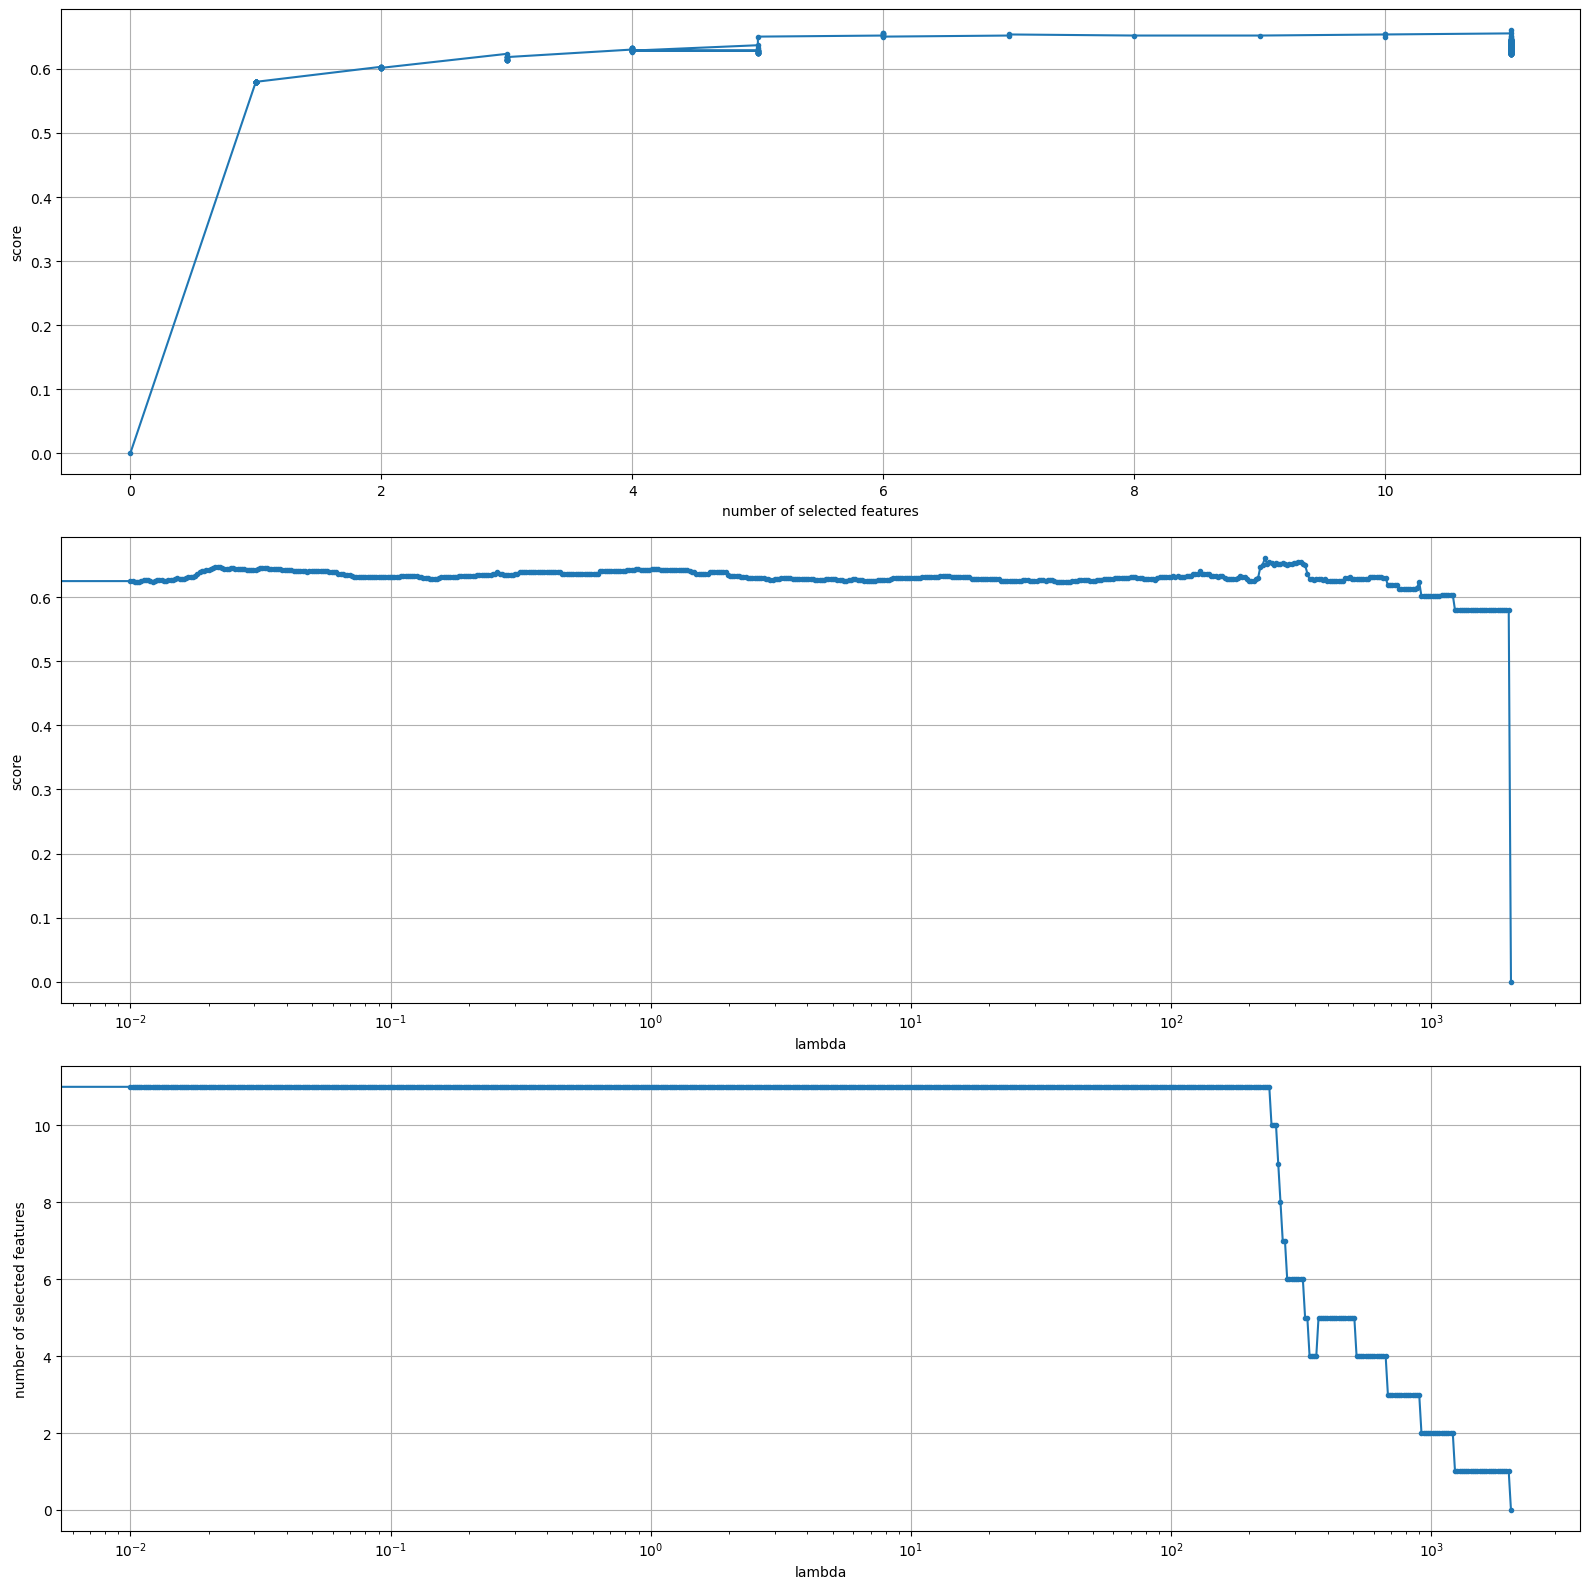

In [21]:
from src.lassonet.plot import plot_path
import matplotlib.pyplot as plt

plot_path(model, path, X_test, y_test)
plt.savefig("figures/cox_regression_efron.png")